In [3]:
import os
import collections
import numpy as np
import pandas as pd
from time import time

from aspects import containers

data_dir = "/home/stavros/DATA/TripAdvisorReviews"

In [4]:
hotel_dir = os.path.join(data_dir, "kresten_royal/the_kresten_royal_villas_1747reviews_withaspects")
data = containers.DataAspects.load(data_dir=hotel_dir)

In [5]:
import gensim
google_vec_file = os.path.join("/home/stavros/DATA/GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)

categories = ["location", "cleanliness", "service", "value"]
# Verify that all categories are in model
for cat in categories:
    print(cat in word2vec)

True
True
True
True


In [27]:
def calculate_distances(phrase: str):
    words = phrase.split(" ")
    d = np.stack([word2vec.distances(word, categories) for word in words if word in word2vec])
    return d.mean(axis=0)

def calculate_vectors(phrase: str):
    words = phrase.split(" ")
    d = np.stack([word2vec[word] for word in words if word in word2vec])
    return d.mean(axis=0)

In [7]:
ordered_phrases = []
for phrase in data.container.words:
    if any([word in word2vec for word in phrase.split(" ")]):
        ordered_phrases.append(phrase)

print(len(ordered_phrases), len(data.container.words))
print(len(ordered_phrases) / len(data.container.words))

2490 2719
0.9157778595071717


In [10]:
categorical_distances = np.array([calculate_distances(phrase) for phrase in ordered_phrases])
categorical_distances.shape

(2490, 4)

In [11]:
np.unique(categorical_distances.argmin(axis=-1), return_counts=True)

(array([0, 1, 2, 3]), array([677, 817, 570, 426]))

In [95]:
phrase2cat = {phrase: (categories[dist.argmin()], dist.min()) 
              for phrase, dist in zip(ordered_phrases, categorical_distances)}
print(len(phrase2cat))

2490


In [103]:
groups_appearances = {cat: collections.Counter({}) for cat in categories}
groups_distance = {cat: collections.Counter({}) for cat in categories}
for phrase, (cat, dist) in phrase2cat.items():
    groups_appearances[cat][phrase] = data.container.appearances[phrase]
    groups_distance[cat][phrase] = 1 - dist

In [94]:
for k, group in groups.items():
    print(k)
    print(group.most_common(30))
    print("\n\n")

location
[('hotel', 529), ('room', 209), ('view', 189), ('time', 176), ('pool', 140), ('place', 139), ('location', 117), ('stay', 114), ('choice', 113), ('selection', 93), ('week', 92), ('thing', 63), ('bar', 59), ('pool areas', 51), ('area', 50), ('one', 49), ('day', 47), ('atmosphere', 46), ('size', 41), ('restaurant', 40), ('days', 38), ('facilities', 38), ('way', 37), ('star', 35), ('weather', 32), ('night', 31), ('start', 29), ('areas', 28), ('town', 28), ('trip', 27)]



cleanliness
[('food', 297), ('rooms', 117), ('quality', 112), ('pools', 88), ('reviews', 86), ('drinks', 83), ('water', 71), ('towels', 64), ('beds', 56), ('beach', 56), ('restaurants', 37), ('things', 36), ('drink', 33), ('eater', 30), ('hotels', 28), ('dishes', 27), ('smell', 26), ('bathroom', 25), ('clean', 23), ('bed', 23), ('guests', 20), ('sunbeds', 19), ('hotel staff', 17), ('eaters', 17), ('air conditioning', 16), ('nights', 16), ('plates', 16), ('lady', 16), ('bars', 14), ('tables', 14)]



service
[('st

In [13]:
categorical_distances_normalized = categorical_distances / categorical_distances.max(axis=1)[:, np.newaxis]

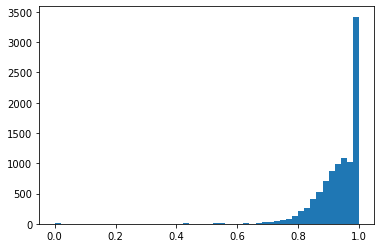

In [19]:
import matplotlib.pyplot as plt
plt.hist(categorical_distances_normalized.ravel(), bins=50)
plt.show()

In [44]:
category_scores = np.zeros(4)
phrase_scores = data.container.scores
for phrase, weights in zip(ordered_phrases, categorical_distances_normalized):
    category_scores += (1 - weights) * (data.container.pos_appearances[phrase] - data.container.neg_appearances[phrase])

In [45]:
for category, score in zip(categories, category_scores):
    print(category, score)

location 762.3741012215614
cleanliness 566.2637028098106
service 578.5940501689911
value 335.4258334040642


In [29]:
phrase_vectors = np.stack([calculate_vectors(phrase) for phrase in ordered_phrases])
print(phrase_vectors.shape)

(2490, 300)


In [31]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=6)

In [35]:
cluster_labels = kmeans.fit_predict(phrase_vectors)
cluster_labels.shape

(2490,)

In [36]:
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([591, 659, 294, 239, 341, 366]))

In [37]:
kmeans.n_clusters

6

In [41]:
ids = [np.where(cluster_labels == i)[0] for i in range(kmeans.n_clusters)]
word_clusters = [collections.Counter({ordered_phrases[i]: data.container.appearances[ordered_phrases[i]] for i in ind})
                 for ind in ids]

In [42]:
for cluster in word_clusters:
    print(len(cluster))

591
659
294
239
341
366


In [43]:
word_clusters[0].most_common()

[('time', 176),
 ('place', 139),
 ('stay', 114),
 ('week', 92),
 ('thing', 63),
 ('us', 61),
 ('one', 49),
 ('day', 47),
 ('touch', 43),
 ('days', 38),
 ('way', 37),
 ('points', 37),
 ('things', 36),
 ('star', 35),
 ('start', 29),
 ('break', 29),
 ('something', 28),
 ('nothing', 26),
 ('guy', 25),
 ('surprise', 25),
 ('side', 24),
 ('man', 19),
 ('anything', 19),
 ('plenty', 18),
 ('lots', 17),
 ('ones', 17),
 ('spot', 17),
 ('bit', 16),
 ('air conditioning', 16),
 ('animation team', 15),
 ('italian', 13),
 ('stuff', 13),
 ('feel', 13),
 ('point', 13),
 ('shorts', 12),
 ('con', 12),
 ('greek', 11),
 ('4', 11),
 ('weeks', 11),
 ('anyone', 10),
 ('impression', 10),
 ('times', 10),
 ('check', 9),
 ('etc', 9),
 ('english', 9),
 ('tip', 9),
 ('team', 8),
 ('lot', 8),
 ('couple', 8),
 ('air con', 8),
 ('everything', 8),
 ('look', 8),
 ('la carte', 7),
 ('fi', 7),
 ('mix', 7),
 ('bits', 7),
 ('road', 7),
 ('guys', 7),
 ('note', 7),
 ('stars', 7),
 ('minute', 7),
 ('word', 7),
 ('end', 6),
 ('